In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
version = '03'

Using TensorFlow backend.


In [2]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)

## Dataset loading

In [3]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [4]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X = np.array(batch_right + batch_left)
y = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [5]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [6]:
X_diff = X[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X[:,:,0])
X_diff[:,:,1] = np.diff(X[:,:,1])

Text(0.5, 0, 'y relative movement (px)')

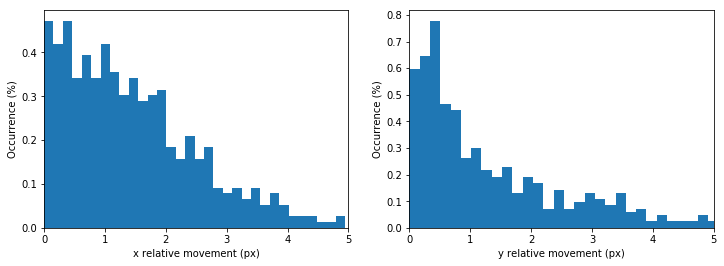

In [7]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)
mask = (sigma_x>0.1)*(sigma_y>0.1)

X_filt = X_diff[mask]
y_filt = y[mask]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

#fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

In [8]:
np.mean(np.std(X_filt[:,:,0], axis=1))

1.4900517595356684

## Training/dev/test set splitting

In [9]:
def create_train_dev_test(X, y, seed=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed, shuffle=True)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = create_train_dev_test(X_filt, y_filt, seed=1)

## Model definition

In [10]:
def create_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_dev.shape[1], 2)))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________


## Model testing

In [11]:
def save_history(history_t, version):
    with open(f'../model_data/history_{version}.pkl', 'wb') as handle:
        pickle.dump(history_t, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
if os.path.isfile(f'../model_data/history_{version}.pkl'):
    with open(f'../model_data/history_{version}.pkl', 'rb') as handle:
        history_trainings = pickle.load(handle)
else:
    history_trainings = {}

Instructions for updating:
Use tf.cast instead.


In [13]:
for lr in [0.01, 0.001, 0.0001, 0.00001]:
    for random_seed in [7, 8]:
        X_train, X_dev, X_test, y_train, y_dev, y_test = create_train_dev_test(X_filt, y_filt, seed=random_seed)
        adam = Adam(lr=lr)
        chk = ModelCheckpoint(f'../models/best_model_{version}.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=0) #monitor='val_acc'
        weights = model.get_weights()
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        
        history_trainings[(lr, random_seed)] = model.fit(X_train, y_train, epochs=200, batch_size=64,
                                                        callbacks=[chk], validation_data=(X_dev, y_dev),
                                                        verbose=2)
        save_history(history_trainings, version=version)
        model.set_weights(weights)

play_bell()

Train on 345 samples, validate on 74 samples
Epoch 1/200
 - 4s - loss: 0.7329 - acc: 0.4870 - val_loss: 0.6996 - val_acc: 0.5405
Epoch 2/200
 - 2s - loss: 0.6981 - acc: 0.5217 - val_loss: 0.6867 - val_acc: 0.5676
Epoch 3/200
 - 2s - loss: 0.6813 - acc: 0.5304 - val_loss: 0.6858 - val_acc: 0.5676
Epoch 4/200
 - 2s - loss: 0.6691 - acc: 0.5681 - val_loss: 0.6957 - val_acc: 0.5405
Epoch 5/200
 - 2s - loss: 0.6627 - acc: 0.5391 - val_loss: 0.6987 - val_acc: 0.4595
Epoch 6/200
 - 2s - loss: 0.6516 - acc: 0.5971 - val_loss: 0.8485 - val_acc: 0.5405
Epoch 7/200
 - 2s - loss: 0.7010 - acc: 0.5536 - val_loss: 0.6916 - val_acc: 0.6216
Epoch 8/200
 - 2s - loss: 0.6605 - acc: 0.5594 - val_loss: 0.7118 - val_acc: 0.5541
Epoch 9/200
 - 2s - loss: 0.6375 - acc: 0.5710 - val_loss: 0.8062 - val_acc: 0.5000
Epoch 10/200
 - 2s - loss: 0.7104 - acc: 0.6058 - val_loss: 0.6970 - val_acc: 0.5405
Epoch 11/200
 - 2s - loss: 0.6648 - acc: 0.5594 - val_loss: 0.7370 - val_acc: 0.5405
Epoch 12/200
 - 2s - loss: 0.

## Training history plot

In [14]:
with open(f'../model_data/history_{version}.pkl', 'rb') as handle:
    history = pickle.load(handle)

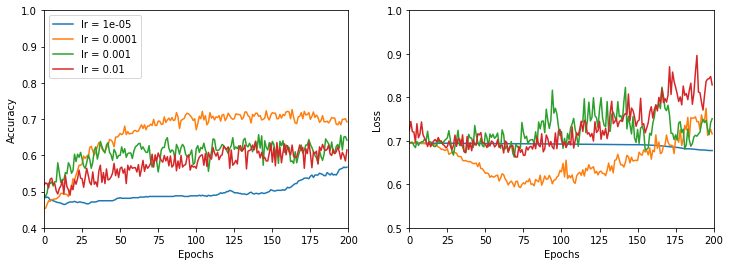

In [23]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,4))
lrs = sorted(set([x[0] for x in history.keys()]))
for lr in lrs:
    accuracy = np.mean([history[i].history['acc'] for i in history if i[0]==lr],0)
    accuracy_val = np.mean([history[i].history['val_acc'] for i in history if i[0]==lr],0)
    line, = ax.plot(accuracy_val, label=f'lr = {lr}')
    #ax.plot(accuracy,  color=line.get_color(), alpha=0.4, linewidth=4)
    
    loss = np.mean([history[i].history['loss'] for i in history if i[0]==lr],0)
    loss_val = np.mean([history[i].history['val_loss'] for i in history if i[0]==lr],0)
    ax2.plot(loss_val, label=f'lr = {lr}', color=line.get_color())
    #ax2.plot(loss,  color=line.get_color(), alpha=0.4, linewidth=4)
    
ax.legend(loc=2)
ax.set_xlim(0, len(accuracy))
ax.set_ylim(0.4, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

ax2.set_xlim(0, len(accuracy))
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

#fig.savefig(f'../plots/model_{version}.png', bbox_inches='tight')

## Building best model

In [29]:

lr = 0.0001
X_train, X_dev, X_test, y_train, y_dev, y_test = create_train_dev_test(X_filt, y_filt, seed=1)
adam = Adam(lr=lr)
chk = ModelCheckpoint(f'../models/best_model_{version}.pkl', monitor='acc', save_best_only=True, mode='max', verbose=0) #monitor='val_acc'
weights = model.get_weights()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history_t = model.fit(X_train, y_train, epochs=300, batch_size=64,
                                                callbacks=[chk], validation_data=(X_dev, y_dev))
model.set_weights(weights)

play_bell()

Train on 345 samples, validate on 172 samples
Epoch 1/300
345/345 [==============================] - 3s 9ms/step - loss: 0.6900 - acc: 0.5333 - val_loss: 0.6870 - val_acc: 0.5174
Epoch 2/300
345/345 [==============================] - 1s 4ms/step - loss: 0.6866 - acc: 0.5391 - val_loss: 0.6832 - val_acc: 0.5174
Epoch 3/300
345/345 [==============================] - 2s 4ms/step - loss: 0.6833 - acc: 0.5449 - val_loss: 0.6800 - val_acc: 0.5291
Epoch 4/300
345/345 [==============================] - 2s 5ms/step - loss: 0.6809 - acc: 0.5449 - val_loss: 0.6773 - val_acc: 0.5233
Epoch 5/300
345/345 [==============================] - 2s 5ms/step - loss: 0.6789 - acc: 0.5478 - val_loss: 0.6752 - val_acc: 0.5291
Epoch 6/300
345/345 [==============================] - 2s 5ms/step - loss: 0.6774 - acc: 0.5507 - val_loss: 0.6731 - val_acc: 0.5349
Epoch 7/300
345/345 [==============================] - 2s 5ms/step - loss: 0.6757 - acc: 0.5507 - val_loss: 0.6714 - val_acc: 0.5349
Epoch 8/300
345/345 [==

## Training history plot

NameError: name 'history_t' is not defined

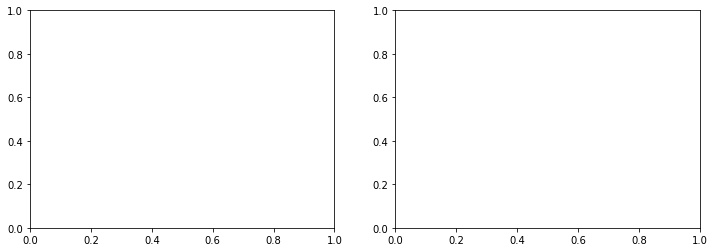

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history_t.history['acc'], label='train')
ax1.plot(history_t.history['val_acc'], label='dev')

ax2.plot(history_t.history['loss'], label='train')
ax2.plot(history_t.history['val_loss'], label='dev')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.legend()
ax2.legend()

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

best_acc = max(history_t.history['val_acc'])
print(f'Best accuracy on the dev set: {best_acc*100:.1f}%')
best_acc_training = max(history_t.history['acc'])
print(f'Best accuracy on the training set: {best_acc_training*100:.1f}%')
#fig.savefig(f'../plots/model_{version}.png', bbox_inches='tight')

## Evaluation of the model

In [33]:
model = load_model(f'../models/best_model_{version}.pkl') # load best model

In [37]:
dev_preds = model.predict_classes(X_dev)
acc_dev = accuracy_score(y_dev, dev_preds)
print(f'Accuracy on the dev set: {acc_dev*100:.1f}%')

training_preds = model.predict_classes(X_train)
acc_training = accuracy_score(y_train, training_preds)
print(f'Accuracy on the training set: {acc_training*100:.1f}%')

test_preds = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, test_preds)
print(f'Accuracy on the training set: {acc_test*100:.1f}%')

Accuracy on the dev set: 88.4%
Accuracy on the training set: 85.8%
Accuracy on the training set: 83.2%


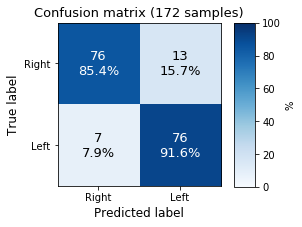

In [41]:
import itertools
from sklearn.metrics import confusion_matrix

#cm = confusion_matrix(y_test, test_preds)
cm = confusion_matrix(y_dev, dev_preds)
#cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_dev.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{version}.png', bbox_inches='tight')